In [96]:
from pyspark import SparkConf,SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,count,mean,udf,sum,when
spark = SparkSession.builder \
    .appName("Typhoon Analyze") \
    .master("local[*]") \
    .getOrCreate()
spark.conf.set("spark.rapids.sql.enable","true")

In [97]:
df = spark.read.option("header", True).csv("../design/data/mode_analysis.csv")

In [98]:
df.show(10)

+--------+----+-----+---+----+--------+---------+--------------------+----------------+----------------------------+
|storm_id|year|month|day|hour|latitude|longitude|               grade|Central pressure|Maximum sustained wind speed|
+--------+----+-----+---+----+--------+---------+--------------------+----------------+----------------------------+
|    5101|1951|    2| 19|   6|    20.0|    138.5| Tropical Depression|            1010|                        NULL|
|    5101|1951|    2| 19|  12|    20.0|    138.5| Tropical Depression|            1010|                        NULL|
|    5101|1951|    2| 19|  18|    23.0|    142.1| Tropical Depression|            1000|                        NULL|
|    5101|1951|    2| 20|   0|    25.0|    146.0|Tropical Cyclone ...|             994|                        NULL|
|    5101|1951|    2| 20|   6|    27.6|    150.6|Tropical Cyclone ...|             994|                        NULL|
|    5101|1951|    2| 20|  12|    28.9|    153.3|Tropical Cyclon

1. 台风路径

In [99]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, when, udf, concat_ws, to_timestamp,lit,unix_timestamp
from geopy.distance import distance
df_track = df.select(
    col("storm_id"),
    col("grade"),
    col("latitude"),
    col("longitude"),
    col("year"),
    col("month"),
    col("day"),
    col("hour")
)
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
df_track = df_track.withColumn(
    "date",
    to_timestamp(concat_ws("-", col("year"), col("month"), col("day"), col("hour")), "yyyy-MM-dd-HH")
)
df_track.show(10)

+--------+--------------------+--------+---------+----+-----+---+----+-------------------+
|storm_id|               grade|latitude|longitude|year|month|day|hour|               date|
+--------+--------------------+--------+---------+----+-----+---+----+-------------------+
|    5101| Tropical Depression|    20.0|    138.5|1951|    2| 19|   6|1951-02-19 06:00:00|
|    5101| Tropical Depression|    20.0|    138.5|1951|    2| 19|  12|1951-02-19 12:00:00|
|    5101| Tropical Depression|    23.0|    142.1|1951|    2| 19|  18|1951-02-19 18:00:00|
|    5101|Tropical Cyclone ...|    25.0|    146.0|1951|    2| 20|   0|1951-02-20 00:00:00|
|    5101|Tropical Cyclone ...|    27.6|    150.6|1951|    2| 20|   6|1951-02-20 06:00:00|
|    5101|Tropical Cyclone ...|    28.9|    153.3|1951|    2| 20|  12|1951-02-20 12:00:00|
|    5101|Tropical Cyclone ...|    31.3|    157.5|1951|    2| 20|  18|1951-02-20 18:00:00|
|    5101|Tropical Cyclone ...|    32.6|    162.1|1951|    2| 21|   0|1951-02-21 00:00:00|

In [100]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

@udf(DoubleType())
def calc_distance(lati_1, long_1, lati_2, long_2):
    if lati_2 is None or long_2 is None:
        return None
    return distance((lati_1, long_1), (lati_2, long_2)).km

#分组
window_spec = Window.partitionBy("storm_id").orderBy("date")

# 获取上一条记录的位置
df_track = df_track.withColumn("prev_latitude", lag("latitude").over(window_spec))
df_track = df_track.withColumn("prev_longitude", lag("longitude").over(window_spec))

# 计算距离
df_track = df_track.withColumn("distance", calc_distance(col("latitude"), col("longitude"), col("prev_latitude"), col("prev_longitude")))

# 获取两条记录之间的时间差
df_track = df_track.withColumn("time_diff", (unix_timestamp(col("date")) - unix_timestamp(lag("date").over(window_spec))) / 3600)

# 计算速度
df_track = df_track.withColumn("speed", col("distance") / col("time_diff"))

df_track = df_track.drop("month", "day", "hour")
df_track.show(10)

+--------+-------------------+--------+---------+----+-------------------+-------------+--------------+------------------+---------+------------------+
|storm_id|              grade|latitude|longitude|year|               date|prev_latitude|prev_longitude|          distance|time_diff|             speed|
+--------+-------------------+--------+---------+----+-------------------+-------------+--------------+------------------+---------+------------------+
|       1|Tropical Depression|     8.8|    137.5|2000|2000-05-04 18:00:00|         NULL|          NULL|              NULL|     NULL|              NULL|
|       1|Tropical Depression|     9.7|    136.0|2000|2000-05-05 00:00:00|          8.8|         137.5|192.54726886145951|      6.0| 32.09121147690992|
|       1|Tropical Depression|     9.9|    135.0|2000|2000-05-05 06:00:00|          9.7|         136.0|111.91371569445359|      6.0|18.652285949075598|
|       1|Tropical Depression|    10.2|    134.4|2000|2000-05-05 12:00:00|          9.9|

In [101]:
from pyspark.sql.functions import col, sum

# 检查缺失部分
null_counts = df_track.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_track.columns])
null_counts.show()
typhoon_id_count = df_track.select("storm_id").distinct().count()
print(f"台风id数: {typhoon_id_count}")
#1881为台风id数，所以没问题

+--------+-----+--------+---------+----+----+-------------+--------------+--------+---------+-----+
|storm_id|grade|latitude|longitude|year|date|prev_latitude|prev_longitude|distance|time_diff|speed|
+--------+-----+--------+---------+----+----+-------------+--------------+--------+---------+-----+
|       0|    0|       0|        0|   0|   0|         1881|          1881|    1881|     1881| 1881|
+--------+-----+--------+---------+----+----+-------------+--------------+--------+---------+-----+

台风id数: 1881


In [102]:
import folium

def get_map_by_id(storm_id):
    typhoon = df_track.filter(col("storm_id") == storm_id).toPandas()
    typhoon['latitude'] = typhoon['latitude'].astype(float)
    typhoon['longitude'] = typhoon['longitude'].astype(float)
    return get_map(typhoon[['latitude', 'longitude']].to_records(index=False), typhoon['date'])

def get_map(coordinates, dates):
    m = folium.Map() #Folium 地图对象 
    m.fit_bounds(coordinates.tolist()) #调整地图视角
    folium.PolyLine(locations=coordinates, color='blue').add_to(m) #绘制一条蓝色的折线，表示台风路径
    folium.Marker(location=coordinates[0], popup="start").add_to(m) #起点标记
    for coord, date in zip(coordinates, dates):
        folium.Circle(location=coord,
                      color='yellow' if date.hour else 'orange').add_to(m)
    return m





map_5101 = get_map_by_id(5101)

In [103]:
map_5101

In [104]:
df_track.coalesce(1).write.mode("overwrite").option("header",True).csv("result/track")

2. 台风分布

In [105]:
from folium.plugins import HeatMap
from pyspark.sql.functions import year
def generate_typhoon_heatmap(df_track, start_year, end_year):
    
# 过滤指定年份范围内的数据
    df_filtered = df_track.filter( (col('year') >= start_year) & (col("year")  <= end_year) )
    typhoon_data = df_filtered.toPandas()
    
    # 创建 Folium 地图对象
    m = folium.Map(location=[20, 120], zoom_start=5)
    
    # 提取坐标数据
    heat_data = [[row['latitude'], row['longitude']] for index, row in typhoon_data.iterrows()]
    
    # 添加热力图层
    HeatMap(heat_data, radius=5, blur=10).add_to(m)
    
    return m



In [106]:
# 生成台风分布图
typhoon_distribution_map = generate_typhoon_heatmap(df_track,2005,2010)
typhoon_distribution_map

3. 统计信息
- 等级趋势
- 强度趋势
- 路径平均偏移距离

In [121]:
# 等级趋势
grade_trend = df.groupBy("year", "grade").count().orderBy("year", "grade")
grade_trend.show(10)

# 强度趋势
intensity_trend = df.groupBy("year").agg(
    mean("Central pressure").alias("avg_central_pressure"),
    mean("Maximum sustained wind speed").alias("avg_wind_speed"),
).orderBy("year")
intensity_trend.show(10)

# 路径平均偏移距离
avg_distance = df_track.groupBy("storm_id").agg(mean("distance").alias("avg_distance"))
avg_distance.show(10)

+----+--------------------+-----+
|year|               grade|count|
+----+--------------------+-----+
|1951|Extra-tropical Cy...|   79|
|1951|Tropical Cyclone ...|  465|
|1951| Tropical Depression|  248|
|1952|Extra-tropical Cy...|  122|
|1952|Tropical Cyclone ...|  529|
|1952| Tropical Depression|  185|
|1953|Extra-tropical Cy...|   87|
|1953|Tropical Cyclone ...|  557|
|1953| Tropical Depression|  220|
|1954|Extra-tropical Cy...|   88|
+----+--------------------+-----+
only showing top 10 rows

+----+--------------------+--------------+
|year|avg_central_pressure|avg_wind_speed|
+----+--------------------+--------------+
|1951|   984.5164141414141|          NULL|
|1952|   986.9366028708134|          NULL|
|1953|   984.5671296296297|          NULL|
|1954|   980.5983493810179|          NULL|
|1955|   990.9184149184149|          NULL|
|1956|   985.9822866344606|          NULL|
|1957|   980.7607891491986|          NULL|
|1958|   983.3846938775511|          NULL|
|1959|   981.812189054726

+--------+------------------+
|storm_id|      avg_distance|
+--------+------------------+
|    1512| 98.43110237173778|
|    6613|  85.5502634159689|
|    6731|108.64279101040407|
|    7711| 156.1086548968117|
|    8304|169.13851267011574|
|    9009| 68.63344375898191|
|     125|108.88777823668867|
|    2110|159.21724244308993|
|    5523|135.34388897478763|
|    5613|174.94854861526622|
+--------+------------------+
only showing top 10 rows



In [122]:
grade_trend.coalesce(1).write.mode("overwrite").option("header",True).csv("result/grade_trend")
intensity_trend.coalesce(1).write.mode("overwrite").option("header",True).csv("result/intensity_trend")
avg_distance.coalesce(1).write.mode("overwrite").option("header",True).csv("result/avg_distance")

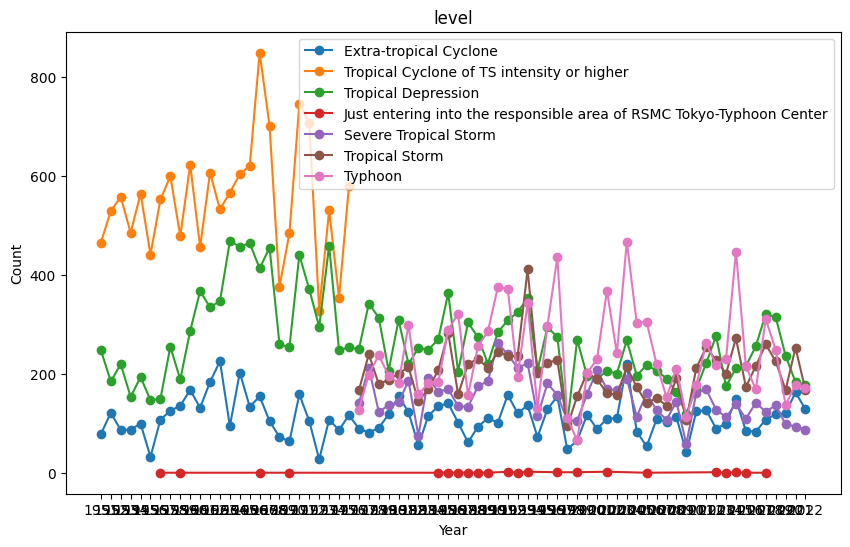

In [119]:
import matplotlib.pyplot as plt

# 等级趋势
grade_trend_pandas = grade_trend.toPandas()
plt.figure(figsize=(10, 6))
for grade in grade_trend_pandas['grade'].unique():
    subset = grade_trend_pandas[grade_trend_pandas['grade'] == grade]
    plt.plot(subset['year'], subset['count'], label=grade, marker='o')

plt.xticks()
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('level')
plt.legend()
plt.show()

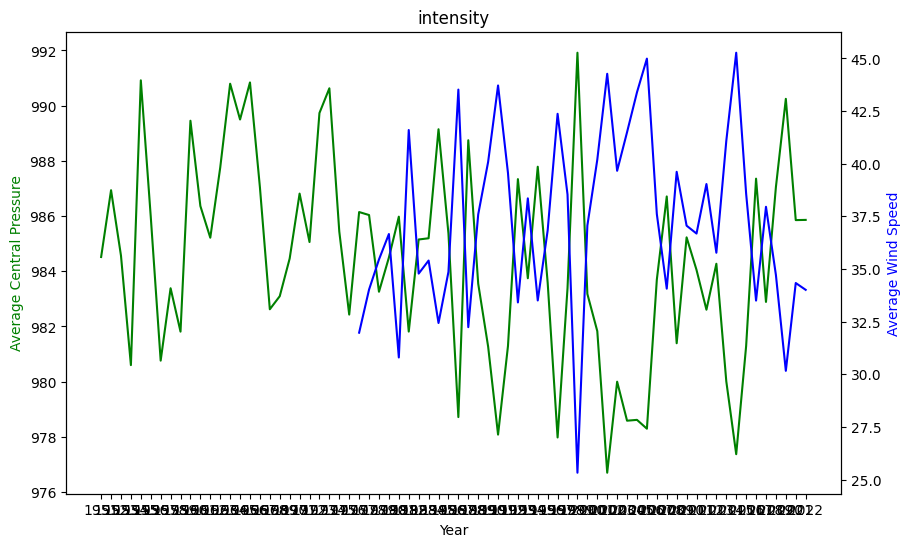

In [109]:
# 强度趋势
intensity_trend_pandas = intensity_trend.toPandas()
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()
ax1.plot(intensity_trend_pandas['year'], intensity_trend_pandas['avg_central_pressure'], 'g-')
ax2.plot(intensity_trend_pandas['year'], intensity_trend_pandas['avg_wind_speed'], 'b-')

ax1.set_xlabel('Year')
ax1.set_ylabel('Average Central Pressure', color='g')
ax2.set_ylabel('Average Wind Speed', color='b')
plt.title('intensity')
plt.show()

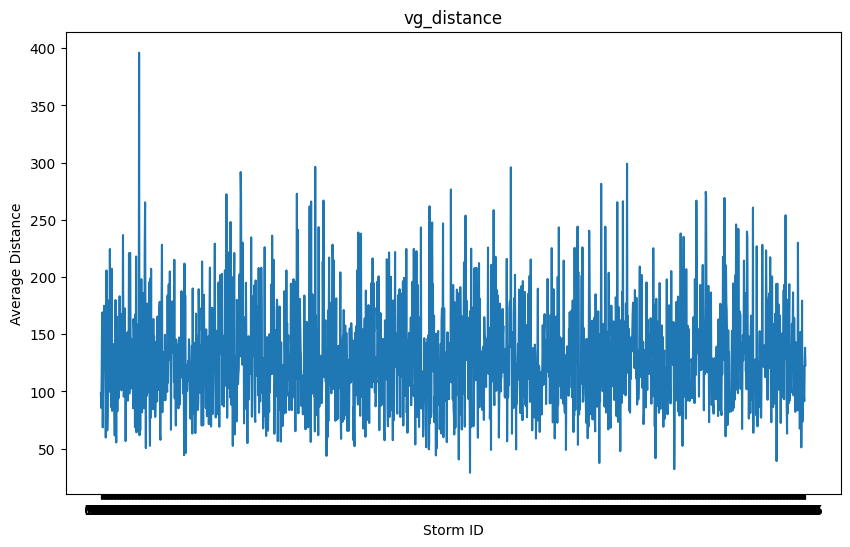

In [110]:
# 路径平均偏移距离
avg_distance_pandas = avg_distance.toPandas()
plt.figure(figsize=(10, 6))
plt.plot(avg_distance_pandas['storm_id'], avg_distance_pandas['avg_distance'])
plt.xlabel('Storm ID')
plt.ylabel('Average Distance')
plt.title('vg_distance')
plt.show()